## Načtení dat ##

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

ddf = (pd.read_csv('edinburgh_bikes.csv').drop(['Unnamed: 0', 'index'], axis=1))

ddf[['started_at', 'ended_at']] = (
    ddf[['started_at', 'ended_at']].apply(pd.to_datetime, format='%Y-%m-%d %H:%M:%S'))

ddf['duration'] = ddf['duration'].apply(lambda x: x/60)  # minutes
ddf.rename(columns={'duration': 'duration_min'}, inplace=True)

## Popis datového souboru ##

In [3]:
ddf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438259 entries, 0 to 438258
Data columns (total 13 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   started_at                 438259 non-null  datetime64[ns]
 1   ended_at                   438259 non-null  datetime64[ns]
 2   duration_min               438259 non-null  float64       
 3   start_station_id           438259 non-null  int64         
 4   start_station_name         438259 non-null  object        
 5   start_station_description  434118 non-null  object        
 6   start_station_latitude     438259 non-null  float64       
 7   start_station_longitude    438259 non-null  float64       
 8   end_station_id             438259 non-null  int64         
 9   end_station_name           438259 non-null  object        
 10  end_station_description    433570 non-null  object        
 11  end_station_latitude       438259 non-null  float64 

In [36]:
# first and last record - timeframe
ddf.sort_values('started_at').iloc[[0,-1],[0,1]]

,started_at,ended_at
0,2018-09-15 08:52:05,2018-09-15 09:11:48
438258,2021-06-30 23:58:33,2021-07-01 00:07:15


In [4]:
ddf.head(3)

,started_at,ended_at,duration_min,start_station_id,start_station_name,start_station_description,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_description,end_station_latitude,end_station_longitude
0,2018-09-15 08:52:05,2018-09-15 09:11:48,19.700000,247,Charlotte Square,North Corner of Charlotte Square,55.952335,-3.207101,259,St Andrew Square,North East corner,55.954728,-3.192653
1,2018-09-15 09:24:33,2018-09-15 09:41:09,16.583333,259,St Andrew Square,North East corner,55.954749,-3.192774,262,Canonmills,near Tesco's,55.962804,-3.196284
2,2018-09-15 09:48:54,2018-09-15 10:46:40,57.766667,262,Canonmills,near Tesco's,55.962804,-3.196284,250,Victoria Quay,Entrance to Scottish Government Office,55.977638,-3.174116


### Chybějící hodnoty ###
- pouze popisky stanic 

In [5]:
ddf.isna().any()

started_at                   False
ended_at                     False
duration_min                 False
start_station_id             False
start_station_name           False
start_station_description     True
start_station_latitude       False
start_station_longitude      False
end_station_id               False
end_station_name             False
end_station_description       True
end_station_latitude         False
end_station_longitude        False
dtype: bool

### Odlehlé hodnoty ###
- trvání výpůjčky (duration)

In [40]:
round(ddf[['duration_min']]
 .describe(percentiles=[.05, .25, .50, .75, .95, .99])
 .drop('count'), 1).T

,mean,std,min,5%,25%,50%,75%,95%,99%,max
duration_min,32.5,94.3,1.0,4.6,10.4,19.4,42.2,90.2,186.5,39389.1


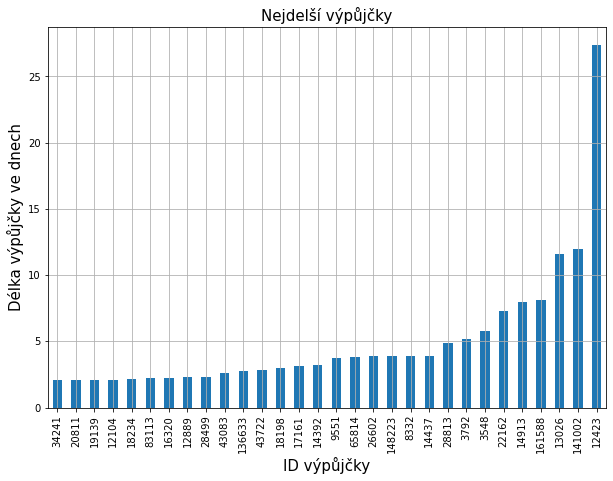

In [6]:
fig, ax = plt.subplots(figsize=(10,7))

# in days
(ddf[['duration_min']]/60/24).sort_values('duration_min').tail(30).plot.bar(ax=ax)

ax.set_title('Nejdelší výpůjčky', fontsize=15)
ax.set_xlabel('ID výpůjčky', fontsize=15)
ax.set_ylabel('Délka výpůjčky ve dnech', fontsize=15)
ax.legend().remove()
ax.grid()
plt.show()

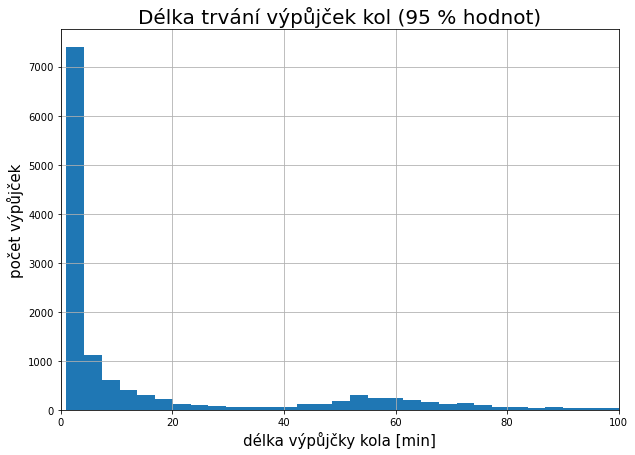

In [44]:
fig, ax = plt.subplots(figsize=(10,7))
ax.hist((ddf['duration_min']).value_counts(), bins=100)

ax.set_xlim(0, 100)
ax.set_title('Délka trvání výpůjček kol (95 % hodnot)', fontsize=20)
ax.set_xlabel('délka výpůjčky kola [min]', fontsize=15)
ax.set_ylabel('počet výpůjček', fontsize=15)
ax.grid()
plt.show()

## Aktivní a neaktivní stanice ##

In [45]:
# List of all stations
s1 = (ddf[['start_station_id', 'start_station_name']]
      .rename(columns={'start_station_id': 'station_ID',
                       'start_station_name': 'station_name'}))
s2 = (ddf[['end_station_id', 'end_station_name']]
      .rename(columns={'end_station_id': 'station_ID',
                       'end_station_name': 'station_name'}))
stations_df = (s1.append(s2)
               .drop_duplicates(subset='station_ID')
               .set_index('station_ID')
               .sort_index())

In [10]:
stations_df.head(3)

,station_name
station_ID,
171,George Square
183,Waverley Bridge
189,City Chambers


In [46]:
activity_df = (stations_df
               .assign(departures_count = ddf.groupby('start_station_id')
                       .count()[['started_at']])
               .assign(arrivals_count = ddf.groupby('end_station_id')
                       .count()[['ended_at']])
               .fillna(0)
               .astype({'departures_count': int, 'arrivals_count': int}))
activity_df['total_count'] = (activity_df['departures_count']
                              + activity_df['arrivals_count'])
activity_df = (activity_df.sort_values('total_count'))
 
activity_df.tail(3)

,station_name,departures_count,arrivals_count,total_count
station_ID,,,,
250,Victoria Quay,10662,15254,25916
1728,Portobello - Kings Road,11843,16656,28499
265,Meadows East,17390,15225,32615


In [53]:
round(activity_df[['total_count']]
 .describe(percentiles=[.05, .10, .25, .50, .75, .90, .95, .99]),0).astype(int).T

,count,mean,std,min,5%,10%,25%,50%,75%,90%,95%,99%,max
total_count,200,4383,5682,1,13,65,442,2171,5972,11053,16353,25942,32615


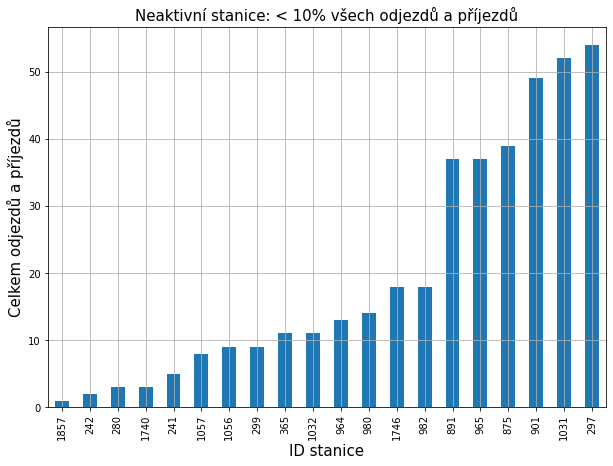

In [54]:
# lowest 10% - inactive
fig, ax = plt.subplots(figsize=(10,7))
activity_df[['total_count']].query('total_count < 64.8').plot.bar(ax=ax)

ax.set_title('Neaktivní stanice: < 10% všech odjezdů a příjezdů', fontsize=15)
ax.set_xlabel('ID stanice', fontsize=15)
ax.set_ylabel('Celkem odjezdů a příjezdů', fontsize=15)
ax.legend().remove()
ax.grid()
plt.show()

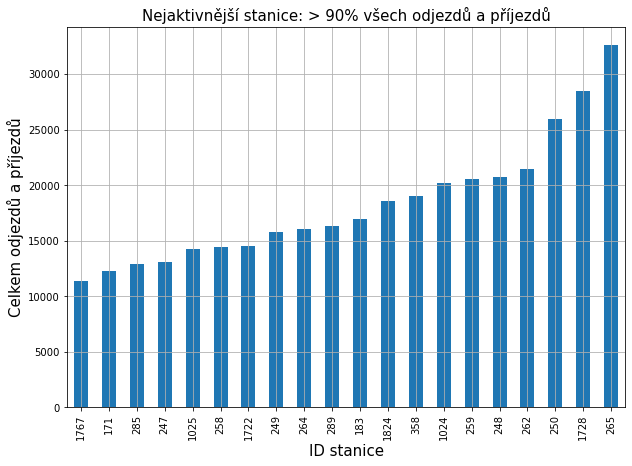

In [55]:
# highest 10% - most active
fig, ax = plt.subplots(figsize=(10,7))
activity_df[['total_count']].query('total_count > 11053').plot.bar(ax=ax)

ax.set_title('Nejaktivnější stanice: > 90% všech odjezdů a příjezdů', fontsize=15)
ax.set_xlabel('ID stanice', fontsize=15)
ax.set_ylabel('Celkem odjezdů a příjezdů', fontsize=15)
ax.legend().remove()
ax.grid()
plt.show()

## Stanice, kde se kola hromadí ##

In [15]:
# hromadí: víc příjezdů než odjezdů
# chybí: víc odjezdů než příjezdů
# scatter plot

activity_df.tail(3)

,station_name,departures_count,arrivals_count,total_count
station_ID,,,,
250,Victoria Quay,10662.0,15254.0,25916.0
1728,Portobello - Kings Road,11843.0,16656.0,28499.0
265,Meadows East,17390.0,15225.0,32615.0
